# Mount Google Drive

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


# Import required libraries

Install required libraries

In [2]:
! pip install transformers datasets evaluate rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=0a5a58cbddc0eafaf71a02e760e827d034c23ad4994e79ae5519ca88f1e11461
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's d

In [1]:
import io
import os
from io import BytesIO

import hydra
import evaluate
import matplotlib.pyplot as plt
import torch
import torchvision
from datasets import load_dataset
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from tqdm import tqdm

os.environ["WANDB_DISABLED"] = "true"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import matplotlib.pyplot as plt
from transformers import TrainerCallback

/Users/harnoorrangi/Documents/Application/image_captioning_application/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/harnoorrangi/Documents/Application/image_captioning_application/.venv/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnin

## Select device

In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"# available GPUs : {torch.cuda.device_count()}")
    print(f"GPU name : {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
    print("No GPU available, using the CPU instead")

No GPU available, using the CPU instead


##  Define Hyperparamters

In [4]:
class config:
    encoder_model = "microsoft/swin-base-patch4-window7-224-in22k"
    decoder_model = "distilbert/distilgpt2"
    cache_dir = "/content/drive/MyDrive/Image_captioning2/data/"
    dataset = "umaru97/flickr30k_train_val_test"
    model = "/content/drive/MyDrive/Image_captioning2/models/"
    trained_model = "/content/drive/MyDrive/Image_captioning2/models/trained/'VIT_gpt2_image_captioning'"
    TRAIN_BATCH_SIZE = 16
    VAL_BATCH_SIZE = 16
    TEST_BATCH_SIZE = 16
    VAL_EPOCHS = 1
    LR = 5e-5
    EPOCHS = 10

# Load and Preprocess data

In [6]:
# Download dataset
train_data = load_dataset(config.dataset, split="train", cache_dir=config.cache_dir)
val_data = load_dataset(config.dataset, split="val", cache_dir=config.cache_dir)
test_data = load_dataset(config.dataset, split="test", cache_dir=config.cache_dir)

# Print dataset details
print(f"Train set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Validation set size: {len(val_data)}")

README.md:   0%|          | 0.00/871 [00:00<?, ?B/s]

Train set size: 29000
Test set size: 1000
Validation set size: 1014


Looking at a couple of examples

In [7]:
train_data[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500>,
 'caption': ['Two young guys with shaggy hair look at their hands while hanging out in the yard.',
  'Two young, White males are outside near many bushes.',
  'Two men in green shirts are standing in a yard.',
  'A man in a blue shirt standing in a garden.',
  'Two friends enjoy time spent together.'],
 'sentids': ['0', '1', '2', '3', '4'],
 'split': 'train',
 'img_id': '0',
 'filename': '1000092795.jpg'}

Caption: ['Two young guys with shaggy hair look at their hands while hanging out in the yard.', 'Two young, White males are outside near many bushes.', 'Two men in green shirts are standing in a yard.', 'A man in a blue shirt standing in a garden.', 'Two friends enjoy time spent together.']


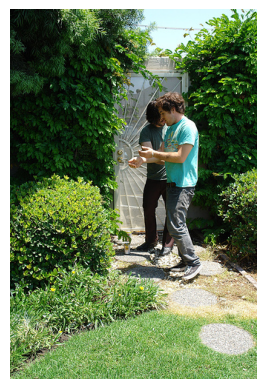

In [8]:
# Print example
example = train_data[0]
# Extract the text and print it
print("Caption:", example["caption"])

# show image
plt.imshow(example["image"])
plt.axis("off")
plt.show()

# Load the Vit image processor and GPT2 tokenizer

In [9]:
image_processor = ViTImageProcessor.from_pretrained(config.encoder_model, cache_dir=config.model)
tokenizer = GPT2TokenizerFast.from_pretrained(config.decoder_model, cache_dir=config.model)
# gpt2 does not have pad_token_id
tokenizer.pad_token = tokenizer.eos_token

loading configuration file preprocessor_config.json from cache at /content/drive/MyDrive/Image_captioning2/models/models--microsoft--swin-base-patch4-window7-224-in22k/snapshots/68dc76680a5bf3bdf670669f3025dc9be2e30781/preprocessor_config.json
size should be a dictionary on of the following set of keys: ({'height', 'width'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}, {'longest_edge'}, {'max_height', 'max_width'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

loading file vocab.json from cache at /content/drive/MyDrive/Image_captioning2/models/models--distilbert--distilgpt2/snapshots/2290a62682d06624634

# Define Hugging face dataset to transform the datasets

In [10]:
class Flickr30kDataset(Dataset):
    def __init__(self, dataset, image_processor, tokenizer, transform=None, max_length=50):
        self.dataset = dataset
        self.image_processor = image_processor
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image and the first caption
        example = self.dataset[idx]
        image = example["image"]
        caption = example["caption"][0]

        # Apply image transformations if provided
        if self.transform:
            image = self.transform(image)

        # Process the image with the image processor
        pixel_values = self.image_processor(images=image, return_tensors="pt").pixel_values.squeeze()

        # Tokenize the caption
        tokenized_caption = self.tokenizer(
            caption, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )

        labels = tokenized_caption["input_ids"].squeeze()

        return {
            "pixel_values": pixel_values,
            "labels": labels,  # Decoder input
        }

In [11]:
# Transform train,valid and test dataset
train_dataset = Flickr30kDataset(train_data, tokenizer=tokenizer, image_processor=image_processor)
val_dataset = Flickr30kDataset(val_data, tokenizer=tokenizer, image_processor=image_processor)
test_dataset = Flickr30kDataset(test_data, tokenizer=tokenizer, image_processor=image_processor)

In [12]:
for item in train_dataset:
    print(item["labels"].shape)
    print(item["pixel_values"].shape)
    break

torch.Size([50])
torch.Size([3, 224, 224])


# Build model

Initlaize encoder, decoder model for finetuning

In [13]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.encoder_model, config.decoder_model).to(device)

config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
    "rose_window, rosette": 9916,
    "roseate_spoonbill, Ajaia_ajaja": 1912,
    "rosebay, Rhododendron_maxima": 19033,
    "rosebud": 17526,
    "rosebud_cherry, winter_flowering_cherry, Prunus_subhirtella": 20120,
    "rosebud_orchid, Cleistes_rosea, Pogonia_rosea": 18520,
    "rosefish, ocean_perch, Sebastodes_marinus": 4079,
    "roselle, rozelle, sorrel, red_sorrel, Jamaica_sorrel, Hibiscus_sabdariffa": 18887,
    "rosemary": 13339,
    "rosemary, Rosmarinus_officinalis": 20711,
    "rosewood, rosewood_tree": 19778,
    "rosilla, Helenium_puberulum": 18324,
    "rosin_bag": 9917,
    "rosinweed, Silphium_laciniatum": 18422,
    "rosita, Centaurium_calycosum": 19186,
    "rosy_boa, Lichanura_trivirgata": 1199,
    "rotary_actuator, positioner": 9918,
    "rotary_engine": 9919,
    "rotary_press": 9920,
    "rotating_mechanism": 9921,
    "rotating_shaft, shaft": 9922,
    "rotavirus": 258,
    "rotgut": 13998,
    "rotifer": 1728,

model.safetensors:   0%|          | 0.00/437M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--microsoft--swin-base-patch4-window7-224-in22k/snapshots/68dc76680a5bf3bdf670669f3025dc9be2e30781/model.safetensors
Some weights of the model checkpoint at microsoft/swin-base-patch4-window7-224-in22k were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of SwinModel were initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224-in22k.
If your task is similar to the task the model of the

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert--distilgpt2/snapshots/2290a62682d06624634c1f46a6ad5be0f47f38aa/config.json
Model config GPT2Config {
  "_name_or_path": "distilbert/distilgpt2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--distilbert--distilgpt2/snapshots/2290a62682d06624634c1f46a6ad5be0f47f38aa/model.safetensors
Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256
}

All model checkpoint weights were used when initializing GPT2LMHeadModel.

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilbert/distilgpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--distilbert--distilgpt2/snapshots/2290a62682d06624634c1f46a6ad5be0f47f38aa/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256
}

Setting `config.is_decoder=True` and `config.add_cross_attention=True` for decoder_config
Generate config GenerationConfig {}



In [ ]:
# Model Configuration for caption generation
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.max_length = 50
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.num_beams = 4

In [15]:
print(model.config.pad_token_id)
print(model.config.eos_token_id)

50256
50256


# Training

### Define metrics to be captured during training

In [16]:
import evaluate

# load the rouge and bleu metrics
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")


def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    preds = eval_pred.predictions

    # Decode the predictions and labels
    pred_str = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels_str = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute the ROUGE score
    rouge_result = rouge.compute(predictions=pred_str, references=labels_str)
    rouge_result = {k: v * 100 for k, v in rouge_result.items()}

    # Compute the BLEU score
    bleu_result = bleu.compute(predictions=pred_str, references=labels_str)

    # Get the length of the generated captions
    generation_length = bleu_result["translation_length"] / len(preds)

    return {**rouge_result, "bleu": bleu_result["bleu"] * 100, "gen_len": generation_length}

### Adding a callback to save training metrics

In [29]:
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []
        self.rouge1_scores = []
        self.rouge2_scores = []
        self.rougel_scores = []
        self.bleu_scores = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.train_loss.append(logs["loss"])
            if "eval_loss" in logs:
                self.eval_loss.append(logs["eval_loss"])
            if "rouge1" in logs:
                self.rouge1_scores.append(logs["rouge1"])
            if "rouge2" in logs:
                self.rouge2_scores.append(logs["rouge2"])
            if "rougeL" in logs:
                self.rougel_scores.append(logs["rougeL"])
            if "bleu" in logs:
                self.bleu_scores.append(logs["bleu"])

### Setup training arguments

In [30]:
training_args = Seq2SeqTrainingArguments(
    output_dir=config.trained_model,
    per_device_train_batch_size=config.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=config.VAL_BATCH_SIZE,
    predict_with_generate=True,
    generation_max_length=50,
    generation_num_beams=4,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_steps=1024,
    num_train_epochs=config.EPOCHS,
    report_to="none",
)

PyTorch: setting up devices


In [ ]:
metrics_callback = MetricsCallback()

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=image_processor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
    callbacks=[metrics_callback],
)

In [34]:
import warnings

# Suppress specific deprecation warning
warnings.filterwarnings("ignore")

In [35]:
# train the model
trainer.train()

***** Running training *****
  Num examples = 29,000
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 18,130
  Number of trainable parameters = 183,626,424


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu,Gen Len
1,1.260400,1.152418,34.299876,11.562199,29.602122,29.604382,7.168469,18.369822
2,1.069700,1.118505,35.543083,12.771978,30.829135,30.849467,8.240362,18.100592
3,0.974100,1.112432,36.014537,12.874800,30.987088,31.017967,8.214446,18.101578
4,0.896600,1.125966,36.459096,12.917513,31.041533,31.093806,8.198884,18.048323
5,0.826600,1.150440,36.265435,12.927844,31.365362,31.396954,8.242022,17.651874
6,0.754100,1.187391,36.523972,12.545607,31.129370,31.171088,7.849541,17.930966



***** Running Evaluation *****
  Num examples = 1014
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 50256,
  "early_stopping": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 50256
}

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu,Gen Len
1,1.260400,1.152418,34.299876,11.562199,29.602122,29.604382,7.168469,18.369822
2,1.069700,1.118505,35.543083,12.771978,30.829135,30.849467,8.240362,18.100592
3,0.974100,1.112432,36.014537,12.874800,30.987088,31.017967,8.214446,18.101578
4,0.896600,1.125966,36.459096,12.917513,31.041533,31.093806,8.198884,18.048323
5,0.826600,1.150440,36.265435,12.927844,31.365362,31.396954,8.242022,17.651874
6,0.754100,1.187391,36.523972,12.545607,31.129370,31.171088,7.849541,17.930966
7,0.698800,1.235342,35.808150,12.065220,30.457121,30.473708,7.844851,18.008876
8,0.642900,1.282477,35.380535,11.619493,30.013798,30.031138,7.383107,18.011834
9,0.605100,1.323372,34.954213,11.404771,29.730422,29.746602,7.147547,17.837278
10,0.574100,1.356530,35.003259,11.360904,29.720764,29.757801,6.957745,17.972387



***** Running Evaluation *****
  Num examples = 1014
  Batch size = 16
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processi

TrainOutput(global_step=18130, training_loss=0.8255196724421927, metrics={'train_runtime': 16443.7519, 'train_samples_per_second': 17.636, 'train_steps_per_second': 1.103, 'total_flos': 3.777984135217152e+19, 'train_loss': 0.8255196724421927, 'epoch': 10.0})

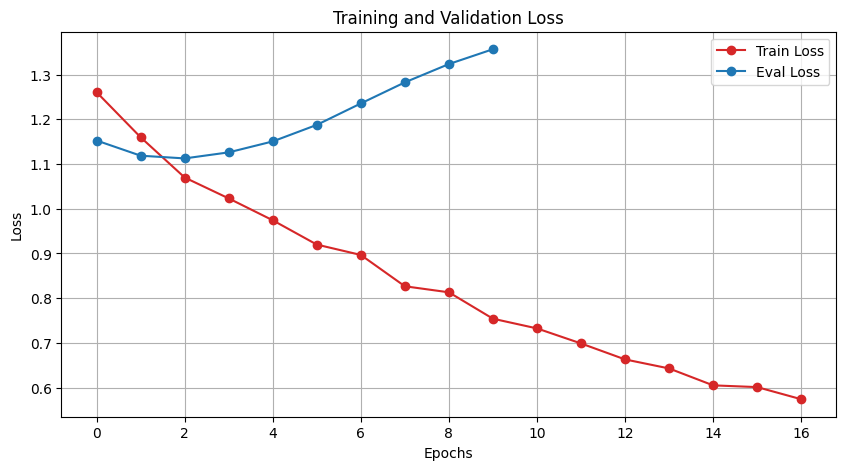

In [45]:
import matplotlib.pyplot as plt

# 1. Plot Loss (Training vs. Validation Loss)
plt.figure(figsize=(10, 5))
plt.plot(metrics_callback.train_loss, label="Train Loss", marker="o", color="tab:red")
plt.plot(metrics_callback.eval_loss, label="Eval Loss", marker="o", color="tab:blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

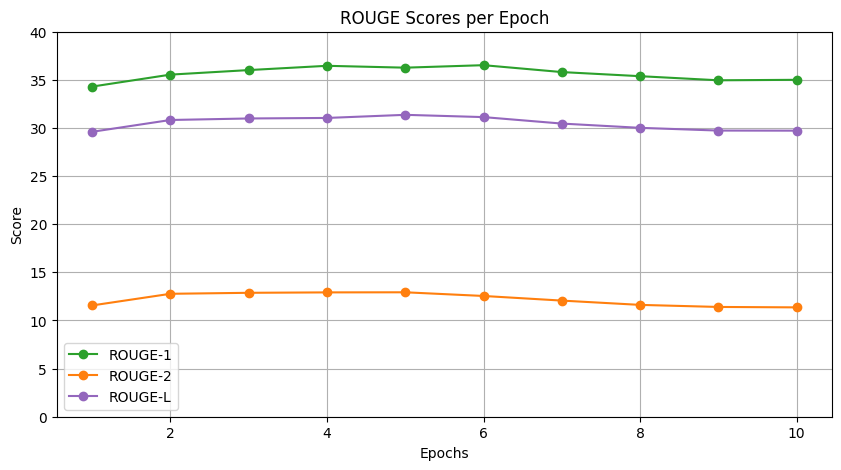

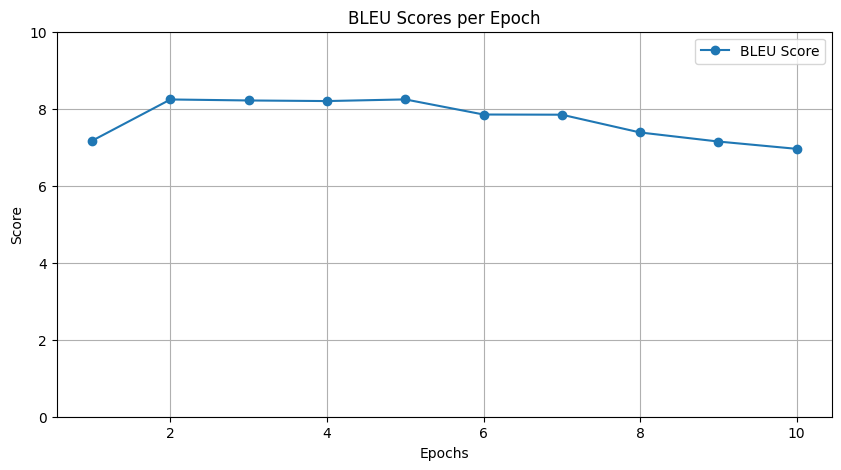

In [63]:
data = {
    "epochs": list(range(1, 11)),
    "rouge_1": [
        34.299876,
        35.543083,
        36.014537,
        36.459096,
        36.265435,
        36.523972,
        35.808150,
        35.380535,
        34.954213,
        35.003259,
    ],
    "rouge_2": [
        11.562199,
        12.771978,
        12.874800,
        12.917513,
        12.927844,
        12.545607,
        12.065220,
        11.619493,
        11.404771,
        11.360904,
    ],
    "rouge_l": [
        29.602122,
        30.829135,
        30.987088,
        31.041533,
        31.365362,
        31.129370,
        30.457121,
        30.013798,
        29.730422,
        29.720764,
    ],
    "bleu": [7.168469, 8.240362, 8.214446, 8.198884, 8.242022, 7.849541, 7.844851, 7.383107, 7.147547, 6.957745],
    "gen_len": [
        18.369822,
        18.100592,
        18.101578,
        18.048323,
        17.651874,
        17.930966,
        18.008876,
        18.011834,
        17.837278,
        17.972387,
    ],
}

# Plotting ROUGE scores with Y range set from 0 to 40
plt.figure(figsize=(10, 5))
plt.plot(data["epochs"], data["rouge_1"], label="ROUGE-1", marker="o", color="tab:green")
plt.plot(data["epochs"], data["rouge_2"], label="ROUGE-2", marker="o", color="tab:orange")
plt.plot(data["epochs"], data["rouge_l"], label="ROUGE-L", marker="o", color="tab:purple")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("ROUGE Scores per Epoch")
plt.ylim(0, 40)  # Setting range to see all metrics in the same visualization scale
plt.legend()
plt.grid(True)
plt.show()

# Plotting BLEU Score with Y range set from 0 to 40
plt.figure(figsize=(10, 5))
plt.plot(data["epochs"], data["bleu"], label="BLEU Score", marker="o", color="tab:blue")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("BLEU Scores per Epoch")
plt.ylim(0, 10)  # Setting range to see BLEU trends in full scale
plt.legend()
plt.grid(True)
plt.show()

In [5]:
!pwd

/Users/harnoorrangi/Documents/Application/image_captioning_application/src/imagecaption/notebooks


In [7]:
trained_model = "/Users/harnoorrangi/Documents/Application/image_captioning_application/src/imagecaption/models/trained2/'VIT_gpt2_image_captioning'"

In [47]:
trainer.save_model(trained_model)

Saving model checkpoint to /content/drive/MyDrive/Image_captioning2/models/trained2/'VIT_gpt2_image_captioning'
Configuration saved in /content/drive/MyDrive/Image_captioning2/models/trained2/'VIT_gpt2_image_captioning'/config.json
Configuration saved in /content/drive/MyDrive/Image_captioning2/models/trained2/'VIT_gpt2_image_captioning'/generation_config.json
Model weights saved in /content/drive/MyDrive/Image_captioning2/models/trained2/'VIT_gpt2_image_captioning'/model.safetensors
Image processor saved in /content/drive/MyDrive/Image_captioning2/models/trained2/'VIT_gpt2_image_captioning'/preprocessor_config.json


# Inference on the test dataset

In [25]:
from transformers import (
    AutoTokenizer,
    GPT2TokenizerFast,
    VisionEncoderDecoderModel,
    ViTFeatureExtractor,
    ViTImageProcessor,
)

# Load the model from the saved directory
model_trained = VisionEncoderDecoderModel.from_pretrained("hrangi/image_caption_trained")
# Move the model to the GPU
# model_trained.to(device)

In [9]:
# Load preprocessor and tokenizer from the trained model

image_processor_trained = ViTImageProcessor.from_pretrained(trained_model)
tokenizer_trained = GPT2TokenizerFast.from_pretrained(config.decoder_model, cache_dir=trained_model)
# gpt2 does not have pad_token_id
tokenizer_trained.pad_token = tokenizer_trained.eos_token

In [23]:
image_processor_trained.push_to_hub("hrangi/image_caption_trained")
tokenizer_trained.push_to_hub("hrangi/image_caption_trained")

CommitInfo(commit_url='https://huggingface.co/hrangi/image_caption_trained/commit/67f929dbd255c0ef080d3d218408d16332fc193b', commit_message='Upload tokenizer', commit_description='', oid='67f929dbd255c0ef080d3d218408d16332fc193b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/hrangi/image_caption_trained', endpoint='https://huggingface.co', repo_type='model', repo_id='hrangi/image_caption_trained'), pr_revision=None, pr_num=None)

In [22]:
model_trained.push_to_hub("hrangi/image_caption_trained")

model.safetensors: 100%|██████████| 735M/735M [08:52<00:00, 1.38MB/s]  


CommitInfo(commit_url='https://huggingface.co/hrangi/image_caption_trained/commit/9dc458a4b7643159fa2f2d86cfd5b31947f70052', commit_message='Upload model', commit_description='', oid='9dc458a4b7643159fa2f2d86cfd5b31947f70052', pr_url=None, repo_url=RepoUrl('https://huggingface.co/hrangi/image_caption_trained', endpoint='https://huggingface.co', repo_type='model', repo_id='hrangi/image_caption_trained'), pr_revision=None, pr_num=None)

In [24]:
# Load preprocessor and tokenizer from the trained model

image_processor_trained = ViTImageProcessor.from_pretrained("hrangi/image_caption_trained")
tokenizer_trained = GPT2TokenizerFast.from_pretrained("hrangi/image_caption_trained")
# # gpt2 does not have pad_token_id
# tokenizer_trained.pad_token = tokenizer_trained.eos_token

In [ ]:
! /Users/harnoorrangi/Downloads/295066459_151954317423896_9219511075862474744_n.jpeg

In [21]:
from PIL import Image

In [26]:
img = "/Users/harnoorrangi/Downloads/295066459_151954317423896_9219511075862474744_n.jpeg"

In [27]:
image = Image.open(img).convert("RGB")

In [12]:
import numpy as np

In [13]:
np.__version__

'1.26.4'

In [14]:
image_processor_trained(image, return_tensors="pt", padding=True)

/Users/harnoorrangi/Documents/Application/image_captioning_application/.venv/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


{'pixel_values': tensor([[[[ 1.2214,  1.2214,  1.2214,  ...,  0.2624,  0.3309,  0.3138],
          [ 1.2214,  1.2557,  1.2557,  ...,  0.3481,  0.3652, -0.4054],
          [ 1.1872,  1.1700,  1.1529,  ...,  0.3652, -0.7479, -1.6555],
          ...,
          [ 0.3823,  0.3823,  0.5707,  ..., -0.5938, -0.5253, -0.5424],
          [ 0.1768,  0.4166,  0.3652,  ..., -0.6794, -0.6794, -0.4739],
          [-0.0801,  0.1939,  0.2967,  ..., -0.4397, -0.6281, -0.6452]],

         [[ 0.7129,  0.7304,  0.6954,  ..., -0.6352, -0.6001, -0.6001],
          [ 0.6604,  0.6779,  0.6954,  ..., -0.5651, -0.5301, -1.0728],
          [ 0.6078,  0.6078,  0.6429,  ..., -0.5126, -1.2654, -2.0007],
          ...,
          [ 0.4678,  0.4678,  0.6604,  ..., -0.4951, -0.4251, -0.4601],
          [ 0.2577,  0.5028,  0.4503,  ..., -0.5826, -0.5826, -0.3725],
          [-0.0049,  0.2752,  0.3803,  ..., -0.3375, -0.5301, -0.5476]],

         [[ 0.4788,  0.4614,  0.4439,  ..., -0.5321, -0.4450, -0.4275],
          [ 0

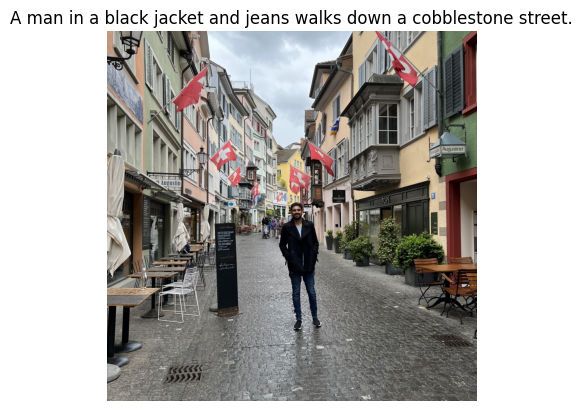

In [29]:
# Generate captions with beam search
generated_caption = tokenizer_trained.decode(
    model_trained.generate(
        image_processor_trained(image, return_tensors="pt", padding=True).pixel_values.to(device),
        max_length=50,
        do_sample=True,  # Enable sampling
        top_k=100,  # Top-k sampling
        top_p=0.92,  # Nucleus sampling
        temperature=0.1,  # Temperature for diversity
    )[0],
    skip_special_tokens=True,
)

# Display the image
plt.imshow(image)

plt.axis("off")
plt.title(generated_caption)  # Set the title to the generated caption
plt.show()